In [1]:
import os
import numpy as np
import skimage
import matplotlib
import matplotlib.pyplot as plt
import cv2
import pickle
import math
import scipy.interpolate
from scipy.ndimage import gaussian_filter
from skimage import color
from matplotlib.colors import LightSource
from mpl_toolkits.mplot3d import Axes3D
from pylab import cm
from mpl_toolkits.mplot3d import proj3d
from sklearn.neighbors import NearestNeighbors
from cp_hw5 import *

In [2]:
def imread(name):
    res = cv2.imread(name)
    res = res[...,::-1] # BGR to RGB
    return res

def imwrite(name, data):
    cv2.imwrite(name, data[:, :, ::-1])

In [3]:
SRC = "bottle"
NUM_IMAGES = 4
SRC_DIR = f"../data/{SRC}"
OUT_DIR = f"../output/{SRC}"

In [4]:
images = []
for i in range(NUM_IMAGES):
    fname = f"image{i+1}.jpg"
    path = f"{SRC_DIR}/{fname}"
    image = imread(path) / 255
    images.append(image)
images = np.stack(images)

HEIGHT = len(images[0])
WIDTH = len(images[0][0])

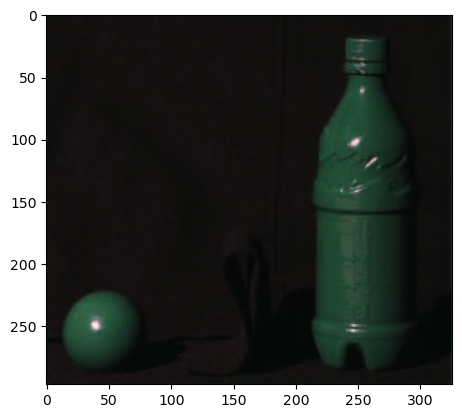

In [5]:
plt.imshow(images[0])

#### Mask the reference and target

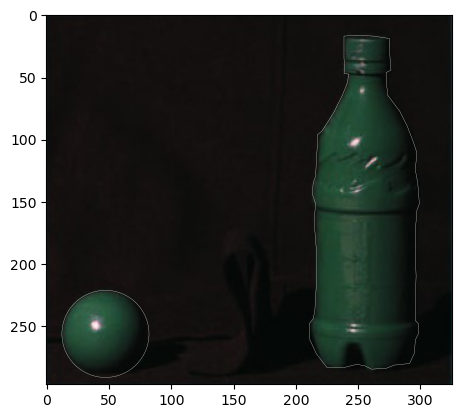

In [6]:
_, ax = plt.subplots()
ax.imshow(images[0])

# reference
center = np.array([47, 256])
radius = 35
ax.add_patch(matplotlib.patches.Circle(center, radius, fill=False, color='white', linewidth=0.2))

# target
# source: https://stackoverflow.com/questions/48301186/cropping-concave-polygon-from-image-using-opencv-python
with open(f"{SRC_DIR}/object_mask.pickle", 'rb') as handle:
    pts = pickle.load(handle)
ax.add_patch(matplotlib.patches.Polygon(pts, fill=False, color='white', linewidth=0.2))

In [7]:
# Generate list of coordinates in reference
# Used https://stackoverflow.com/questions/21339448/how-to-get-list-of-points-inside-a-polygon-in-python
x, y = np.meshgrid(np.arange(HEIGHT), np.arange(WIDTH)) # make a canvas with coordinates
x, y = x.flatten(), y.flatten()
points = np.vstack((x,y)).T
reference_points = points[np.linalg.norm(points - center, axis=1) <= radius]

# Generate list of coordinates in target
# Used https://stackoverflow.com/questions/21339448/how-to-get-list-of-points-inside-a-polygon-in-python
p = matplotlib.path.Path(pts) # make a polygon
grid = p.contains_points(points)
target_points = points[grid]

#### Get the observation vectors

In [8]:
reference_observations = images[:,reference_points[:,0],reference_points[:,1],:] # NUM_IMAGES x NUM_REFERENCE_PIXELS x 3
reference_observations = np.swapaxes(reference_observations, 0, 1) # NUM_REFERENCE_PIXELS x NUM_IMAGES x 3
reference_observations = np.reshape(reference_observations, (len(reference_observations), -1))

target_observations = images[:,target_points[:,0],target_points[:,1],:] # NUM_IMAGES x NUM_TARGET_PIXELS x 3
target_observations = np.swapaxes(target_observations, 0, 1) # NUM_TARGET_PIXELS x NUM_IMAGES x 3
target_observations = np.reshape(target_observations, (len(target_observations), -1))

print(reference_observations.shape, target_observations.shape)

(3853, 12) (18399, 12)


#### Calculate normals at each target coordinate

In [9]:
# For each target observation vector, find index of nearest reference observation vector
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(reference_observations)
_, indices = nbrs.kneighbors(target_observations)
indices = indices.flatten()

# Convert indices into image coordinates
coords = reference_points[indices]

# Convert image coordinates to normals
unit_circle_coords = (coords - center) / radius
z_coords = np.sqrt(1-np.linalg.norm(unit_circle_coords,axis=1)**2)
normals = np.stack([unit_circle_coords[:,0], unit_circle_coords[:,1], z_coords], axis=1)

print(normals.shape)

(18399, 3)


#### Get normal map

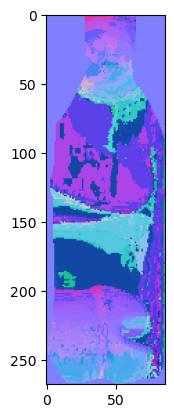

In [10]:
rect = cv2.boundingRect(target_points)
x,y,w,h = rect
normal_map = np.zeros((h,w,3))
normal_map[:,:,2] = 1 # for background just point towards us
for i in range(len(target_points)):
     normal_map[target_points[i][1]-y][target_points[i][0]-x] = normals[i]
plt.imshow((normal_map+1)/2)

#### Integrate normal map to get depths

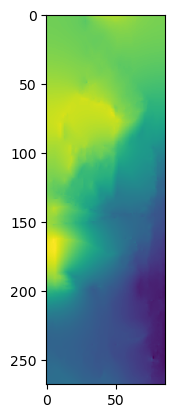

In [11]:
def get_heightmap(normals):
    eps = 0.0000000001
    dfdx = normals[:,:,0] / (normals[:,:,2] + eps)
    dfdy = normals[:,:,1] / (normals[:,:,2] + eps)
    heights = integrate_poisson(dfdx, dfdy)
    heights = (heights - heights.min()) / (heights.max() - heights.min())
    return heights
heights = get_heightmap(normal_map)
plt.imshow(heights)

In [12]:
def plot_surface(name, Z, height, angle):
    # Z is an HxW array of surface depths
    H, W = Z.shape
    x, y = np.meshgrid(np.arange(0,W), np.arange(0,H))
    # set 3D figure
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    # add a light and shade to the axis for visual effect
    # (use the ‘-’ sign since our Z-axis points down)
    ls = LightSource()
    color_shade = ls.shade(-Z, plt.cm.gray)
    # display a surface
    # (control surface resolution using rstride and cstride)
    surf = ax.plot_surface(x, y, -Z, facecolors=color_shade, rstride=4, cstride=4)
    ax.view_init(elev=height, azim=angle)
    # turn off axis
    plt.axis('off')
    if name is not None:
        plt.savefig(name, bbox_inches='tight')
    plt.show()

C:\Users\Ldori\AppData\Local\Temp\ipykernel_34156\557869803.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


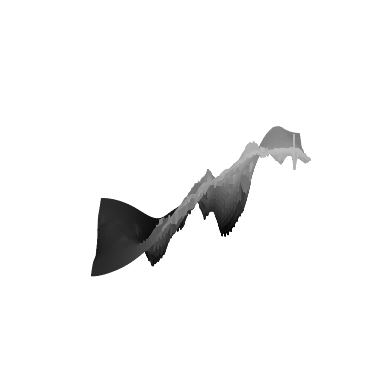

In [15]:
plot_surface(None, heights, 20, 0)